#### Police Reported Crime Trends Analysis: West Yorkshire (April-September 2020)

This analysis examines crime data from West Yorkshire Police covering six months during 2020. This period is particularly interesting as it coincides with the early months of the COVID-19 pandemic and associated lockdown measures, which may have influenced crime patterns.


In [57]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from datetime import datetime
print("\n1. DATA LOADING")
def load_crime_data(data_folder="../data"):
    months = ['2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09']
    dataframes = []
    loading_summary = []
    print("Loading crime data files...")
    # Iterate through each month and load the corresponding file
    for month in months:
        # Construct the filename based on the month
        filename = f"{month}-west-yorkshire-street.csv"
        file_path = os.path.join(data_folder, filename)
        # Check if file exists
        if not os.path.exists(file_path):
            loading_summary.append({
                'Month': month,
                'Filename': filename,
                'Rows': 0,
                'Columns': 0,
                'Status': 'File not found'
            })
            print(f"✗ {month}: File not found - {filename}")
            continue     
        # Load the CSV file
        df = pd.read_csv(file_path)      
        dataframes.append(df)
        print(f"✓ {month}: {len(df):,} records loaded from {filename}")
    # Combine all dataframes
    if dataframes:
        combined_df = pd.concat(dataframes, ignore_index=True)
        print(f"\n Successfully combined data from {len(dataframes)} files")
        print(f" Total records loaded: {len(combined_df):,}")
        return combined_df, pd.DataFrame(loading_summary)
        return None, pd.DataFrame(loading_summary)
# Load the data
crime_data, loading_summary = load_crime_data()


1. DATA LOADING
Loading crime data files...
✓ 2020-04: 21,785 records loaded from 2020-04-west-yorkshire-street.csv
✓ 2020-05: 24,657 records loaded from 2020-05-west-yorkshire-street.csv
✓ 2020-06: 26,730 records loaded from 2020-06-west-yorkshire-street.csv
✓ 2020-07: 29,278 records loaded from 2020-07-west-yorkshire-street.csv
✓ 2020-08: 29,433 records loaded from 2020-08-west-yorkshire-street.csv
✓ 2020-09: 27,015 records loaded from 2020-09-west-yorkshire-street.csv

 Successfully combined data from 6 files
 Total records loaded: 158,898


In [58]:
# 2. DATA SUMMARY
print("\n2. DATA SUMMARY")
def summarise_dataframe(df):
    print("\nCOLUMN DETAILS")
    print(f"{'No.':<3} {'Column':<15} {'Type':<8} {'Non-null':>8} {'Non-%':>6} {'Miss':>8} {'Miss-%':>6}")
    total_rows = len(df)
    for i, col in enumerate(df.columns, 1):
        non_null = df[col].notna().sum()
        missing = total_rows - non_null
        non_null_pct = (non_null / total_rows) * 100
        missing_pct = (missing / total_rows) * 100
        print(f"{i:<3} {col[:15]:<15} {str(df[col].dtype)[:8]:<8} {non_null:>8} {non_null_pct:>5.0f}% {missing:>8} {missing_pct:>5.0f}%")
data_summary = summarise_dataframe(crime_data)


2. DATA SUMMARY

COLUMN DETAILS
No. Column          Type     Non-null  Non-%     Miss Miss-%
1   Unnamed: 0      int64      158898   100%        0     0%
2   Crime ID        object     129209    81%    29689    19%
3   Month           object     156898    99%     2000     1%
4   Falls within    object     127620    80%    31278    20%
5   Longitude       float64    153411    97%     5487     3%
6   Latitude        float64    153411    97%     5487     3%
7   Location        object     156898    99%     2000     1%
8   LSOA code       object     153410    97%     5488     3%
9   LSOA name       object     153410    97%     5488     3%
10  Crime type      object     156898    99%     2000     1%
11  Last outcome ca object     127564    80%    31334    20%
12  Context         float64         0     0%   158898   100%
13  Reported by     object     135113    85%    23785    15%


In [59]:
def analyse_data_anomalies(df):
    print("\n3. DATA ANOMALIES AND PATTERNS")
    
    # Analysis
    asb_missing = len(df[(df['Crime type'] == 'Anti-social behaviour') & df['Crime ID'].isna()])
    actual_dups = df[df['Crime ID'].notna()]['Crime ID'].duplicated().sum()
    missing_essential = df[['Month', 'Crime type']].isna().any(axis=1).sum()
    
    # Only count invalid coordinates where coordinates exist
    has_coords = df.dropna(subset=['Longitude', 'Latitude'])
    invalid_coords = ((has_coords['Longitude'] < -8) | (has_coords['Longitude'] > 2) | 
                     (has_coords['Latitude'] < 49) | (has_coords['Latitude'] > 61)).sum()
    print(f"   • Complete duplicates: {df.duplicated().sum():,}")
    print(f"   • Missing Crime IDs: {df['Crime ID'].isna().sum():,} (ASB: {asb_missing:,})")
    print(f"   • Duplicate Crime IDs: {actual_dups:,}")
    print(f"   • Missing Month/Crime type: {missing_essential:,}")
    print(f"   • Invalid coordinates: {invalid_coords:,}")   
    # Cleaning data
    df_cleaned = df.drop_duplicates()
    df_cleaned = df_cleaned.dropna(subset=['Month', 'Crime type'])
    non_null_ids = df_cleaned[df_cleaned['Crime ID'].notna()]
    null_ids = df_cleaned[df_cleaned['Crime ID'].isna()]
    non_null_cleaned = non_null_ids.drop_duplicates(subset=['Crime ID'], keep='first')
    df_cleaned = pd.concat([non_null_cleaned, null_ids], ignore_index=True)
    invalid_mask = ((df_cleaned['Longitude'] < -8) | (df_cleaned['Longitude'] > 2) | 
                   (df_cleaned['Latitude'] < 49) | (df_cleaned['Latitude'] > 61))
    df_cleaned = df_cleaned[~invalid_mask]
    print(f"CLEANING: {len(df):,} → {len(df_cleaned):,} records ({len(df_cleaned)/len(df)*100:.1f}% retained)")
    return df_cleaned

crime_data_cleaned = analyse_data_anomalies(crime_data)


3. DATA ANOMALIES AND PATTERNS
   • Complete duplicates: 1
   • Missing Crime IDs: 29,689 (ASB: 29,314)
   • Duplicate Crime IDs: 2
   • Missing Month/Crime type: 2,000
   • Invalid coordinates: 118
CLEANING: 158,898 → 156,778 records (98.7% retained)


4. DATA VISUALIsATION - Part 1


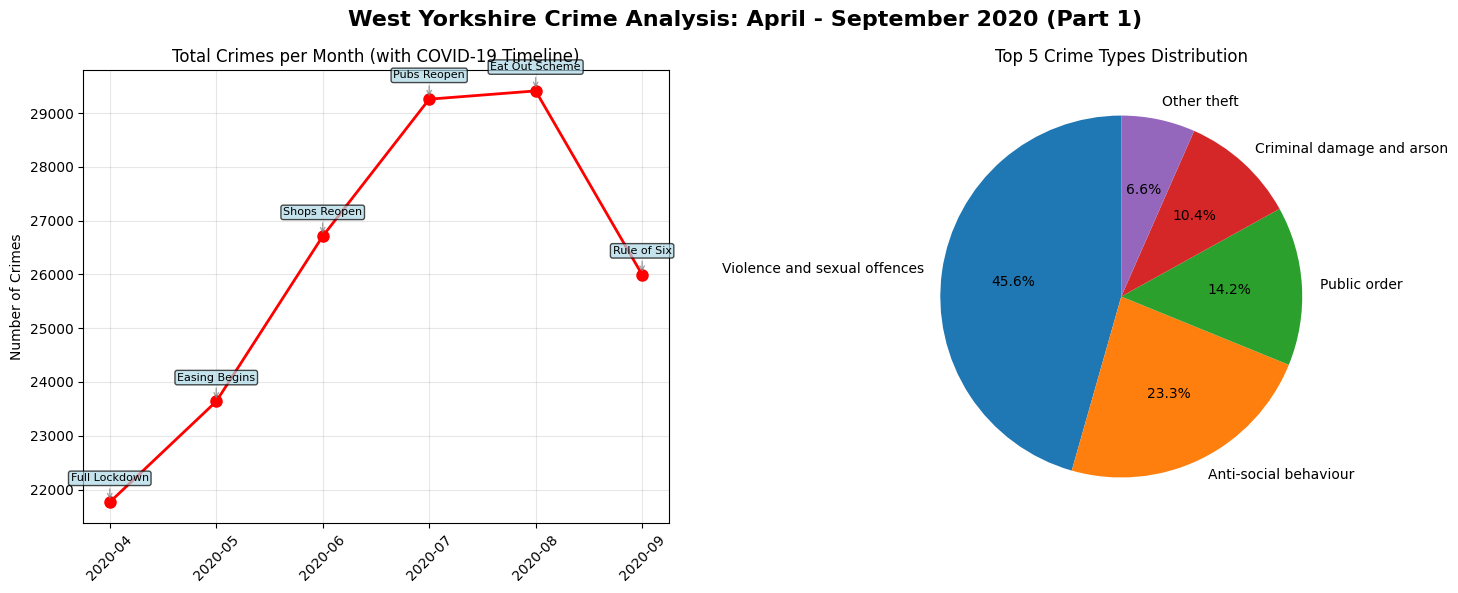

In [67]:
# 4. DATA VISUALIsATION - Part 1
print("4. DATA VISUALIsATION - Part 1")
# Use cleaned data for analysis 
clean_data = crime_data_cleaned
# Set up first figure with 2 subplots (1 and 2)
plt.rcParams['figure.figsize'] = (15, 6)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('West Yorkshire Crime Analysis: April - September 2020 (Part 1)', fontsize=16, fontweight='bold')
# 1. Monthly totals WITH COVID-19 timeline
monthly_totals = clean_data.groupby('Month').size()
ax1.plot(monthly_totals.index, monthly_totals.values, marker='o', linewidth=2, markersize=8, color='red')
# Add COVID-19 context annotations
covid_events = {
    '2020-04': 'Full Lockdown',
    '2020-05': 'Easing Begins', 
    '2020-06': 'Shops Reopen',
    '2020-07': 'Pubs Reopen',
    '2020-08': 'Eat Out Scheme',
    '2020-09': 'Rule of Six'
}
months = list(monthly_totals.index)
for i, month in enumerate(months):
    if month in covid_events:
        ax1.annotate(covid_events[month], 
                     xy=(i, monthly_totals[month]),
                     xytext=(0, 15), textcoords='offset points',
                     ha='center', fontsize=8,
                     bbox=dict(boxstyle='round,pad=0.2', facecolor='lightblue', alpha=0.7),
                     arrowprops=dict(arrowstyle='->', color='gray', alpha=0.7))
ax1.set_title('Total Crimes per Month (with COVID-19 Timeline)')
ax1.set_ylabel('Number of Crimes')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)
# 2. Top 5 crime types pie chart
top_5_crimes = clean_data['Crime type'].value_counts().head(5)
ax2.pie(top_5_crimes.values, labels=top_5_crimes.index, autopct='%1.1f%%', startangle=90)
ax2.set_title('Top 5 Crime Types Distribution')
plt.tight_layout()
plt.show()

4. DATA VISUALIsATION - Part 2


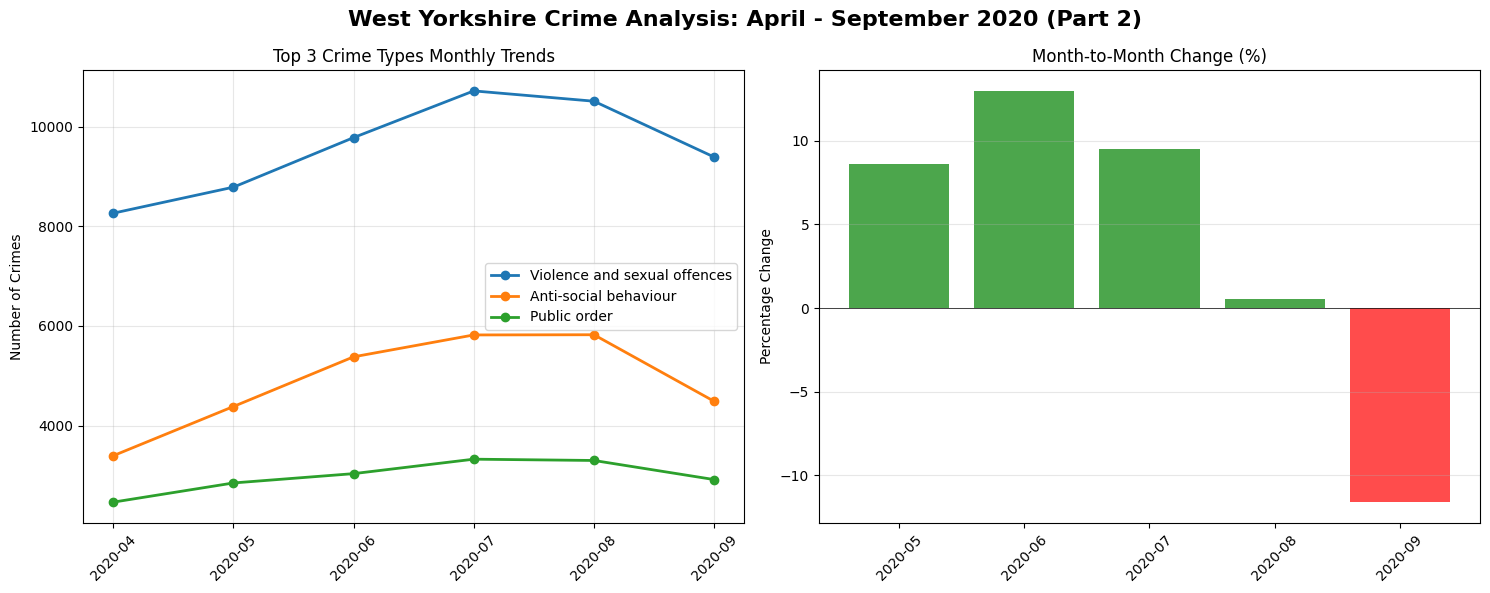

In [68]:
# 4. DATA VISUALISATION - Part 2
print("4. DATA VISUALIsATION - Part 2")
# Set up second figure with 2 subplots (3 and 4)
plt.rcParams['figure.figsize'] = (15, 6)
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('West Yorkshire Crime Analysis: April - September 2020 (Part 2)', fontsize=16, fontweight='bold')
# 3. Top 3 crime types trends
top_3_crimes = clean_data['Crime type'].value_counts().head(3).index
for crime_type in top_3_crimes:
    crime_monthly = clean_data[clean_data['Crime type'] == crime_type].groupby('Month').size()
    ax3.plot(crime_monthly.index, crime_monthly.values, marker='o', label=crime_type, linewidth=2)
ax3.set_title('Top 3 Crime Types Monthly Trends')
ax3.set_ylabel('Number of Crimes')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)
# 4. Month-to-month changes
monthly_changes = monthly_totals.pct_change().dropna() * 100
colors = ['green' if x > 0 else 'red' for x in monthly_changes.values]
bars = ax4.bar(range(len(monthly_changes)), monthly_changes.values, color=colors, alpha=0.7)
ax4.set_title('Month-to-Month Change (%)')
ax4.set_ylabel('Percentage Change')
ax4.set_xticks(range(len(monthly_changes)))
ax4.set_xticklabels(monthly_changes.index, rotation=45)
ax4.grid(True, alpha=0.3, axis='y')
ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

##### Key Findings
1. **Data Quality**: The dataset contains 2,121 records with missing or anomalous data, which have been cleaned for analysis.
2. **Crime Trends**: 
    - April, a period of "Full Lockdown," recorded the lowest number of crimes, around 21,785. As lockdown measures gradually eased through May ("Easing Begins"), June ("Shops Reopen"), and July ("Pubs Reopen"), there was a general increase in reported crimes. A peak in crime numbers was observed in July and August, reaching approximately 29,000 records, before a slight decline in September, which saw the implementation of the "Rule of Six".
    - The most common crime types included "Violence and Sexual Offences," "Anti-Social Behaviour," and "Public Order Offences."
    - Analysing the percentage change month-to-month, the period from April to July saw consistent increases, with notable rises between May and June, and June and July. Conversely, a decrease in total crime was observed from August to September.
    - The monthly trends for these top three crime types indicated that "Violence and sexual offences" generally increased from April to August before a slight dip in September. "Anti-social behaviour" and "Public order" also showed overall increases over the analysed period.
##### Next Steps
- Geospatial Analysis: Leverage the 'Longitude' and 'Latitude' data to conduct a detailed geospatial analysis.
- scripts to automate data cleaning and visualisation processes for future datasets.
- consideration of using streamlit for interactive visualisations and dashboards.